# Init

In [1]:
!nvidia-smi

Thu Dec 22 13:22:34 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.23                 Driver Version: 370.23                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:04:00.0     Off |                  N/A |
| 23%   29C    P8    24W / 250W |  11707MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    On   | 0000:05:00.0     Off |                  N/A |
| 23%   30C    P8    23W / 250W |      0MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import re, os, sys
tf.__version__

def create_session():
    config = tf.ConfigProto(log_device_placement=True, graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
    return tf.InteractiveSession(config=config)

# Setup utilities to parse __LOG_MEMORY__ statements in command-line
#tensor_allocation_regex = re.compile(r"allocated_bytes: (?P<allocated_bytes>\d+).*.*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")
# allocated_bytes: 2400000 allocator_name: "cpu"
tensor_allocation_regex = re.compile("""MemoryLogTensorAllocation.*?step_id: (?P<step_id>[-0123456789]+).*kernel_name: \"(?P<kernel_name>[^"]+)\".*?allocated_bytes: (?P<allocated_bytes>\d+).*allocator_name: \"(?P<allocator_name>[^"]+)\".*.*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)""")
tensor_output_regex = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*allocated_bytes: (?P<allocated_bytes>\d+).*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)""")   
tensor_output_regex_no_bytes = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*timestamp (?P<timestamp>\d+)""")   
tensor_deallocation_regex = re.compile(r"allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")

#"MemoryLogStep { step_id: 2 handle: "->/group_deps/0/;1" } timestamp 5673393661785237'"
tensor_logstep_regex = re.compile("""MemoryLogStep.*?step_id: (?P<step_id>[-0123456789]+).*?.*timestamp (?P<timestamp>\d+)""")

def _parse_logline(l):
    # There are 4 kinds of lines with __LOG_MEMORY__ tag
    # MemoryLogTensorDeallocation, MemoryLogTensorAllocation, MemoryLogStep,
    #
    # Example lines for debugging:
    # MemoryLogTensorDeallocation
    # 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 2 allocator_name: "cpu" } timestamp 5143420588459765
    
    # MemoryLogTensorAllocation
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 has_single_reference: true ptr: 29496256 } } } timestamp 5143420588526034

    # MemoryLogStep
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 1 handle: "->Print:0//0/;0" } timestamp 5143420588718348

    # MemoryLogTensorOutput
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Const" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 ptr: 29496256 } } } timestamp 5143420588932740
     
    # some weird initialization step 
    # if "step_id: -6" in l:
    #    return {}
    
    if 'MemoryLogTensorOutput' in l:
        m = tensor_output_regex.search(l)
        # some Shape lines are missing bytes info, ie # I 5162643141.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 5 kernel_name: "gradients/Shape" tensor { dtype: DT_INT32 shape { dim { } } } } timestamp 5162643141310124
        if not m:
            m = tensor_output_regex_no_bytes.search(l)

        assert m, l
        d = m.groupdict()
        d["type"] = "MemoryLogTensorOutput"
            
    elif 'MemoryLogTensorAllocation' in l:
        m = tensor_allocation_regex.search(l)
        assert m, l
        d = m.groupdict()
        d["type"] = "MemoryLogTensorAllocation"
    elif 'MemoryLogTensorDeallocation' in l:
        m = tensor_deallocation_regex.search(l)
        assert m, l
        d = m.groupdict()
        d["type"] = "MemoryLogTensorDeallocation"
    elif 'MemoryLogStep' in l:
        m = tensor_logstep_regex.search(l)
        assert m, l
        d = m.groupdict()
        d["type"] = "MemoryLogStep"
    else:
        assert False, "Unknown log line"
        
    if not "allocation_id" in d:
        d["allocation_id"] = "-1"

    d["line"] = l
    d["timestamp"] = int(d["timestamp"])
    return d

def memory_timeline(output):
    def get_alloc_names(allocation_id):
        for entry in allocation_map[allocation_id]:
            kernel_name = entry.get("kernel_name", "unknown")
            if not "unknown" in kernel_name.lower():
                return kernel_name+"("+allocation_id+")"
        return "("+allocation_id+")"

    def get_alloc_bytes(allocation_id):
        for entry in allocation_map[allocation_id]:
            if "allocated_bytes" in entry:
                return entry["allocated_bytes"]
        return "0"

    def get_alloc_type(allocation_id):
        for entry in allocation_map[allocation_id]:
            if "allocator_name" in entry:
                return entry["allocator_name"]
        return "0"

    parsed_lines = [_parse_logline(l) for l in output.split("\n") if '__LOG_MEMORY__' in l]
    parsed_lines.sort(key=lambda l: l["timestamp"])
    first_timestamp = parsed_lines[0]["timestamp"]

    allocation_map = {} # map of allocation_id->parsed_logline of allocation
    for line in parsed_lines:
        if line["type"] == "MemoryLogTensorAllocation" or line["type"] == "MemoryLogTensorOutput":
            allocation_map.setdefault(line["allocation_id"], []).append(line)

    result = []
    for line in parsed_lines:
        assert "allocation_id" in line
        alloc_names = get_alloc_names(line["allocation_id"])
        alloc_bytes = get_alloc_bytes(line["allocation_id"])
        alloc_type = get_alloc_type(line["allocation_id"])
        if line["type"] == "MemoryLogTensorOutput":
            continue
        if line["type"] == "MemoryLogTensorDeallocation":
            alloc_bytes = "-" + alloc_bytes
        result.append((line["timestamp"]-first_timestamp, alloc_names, alloc_bytes, alloc_type))
    return result


def print_memory_timeline(stderr, gpu_only=False):
    total_memory = 0
    for record in memory_timeline(stderr):
        timestamp, kernel_name, allocated_bytes, allocator_type = record
        allocated_bytes = int(allocated_bytes)
        if gpu_only:
            if not allocator_type.startswith("gpu"):
                continue
        if abs(allocated_bytes)<1000:
            continue  # ignore small allocations
        total_memory += allocated_bytes
        print("%9d %40s %11d %11d %s"%(timestamp, kernel_name, allocated_bytes, total_memory, allocator_type))

def plot_memory_timeline(stderr, gpu_only=False):
    total_memory = 0
    timestamps = []
    data = []
    for record in memory_timeline(stderr):
        if gpu_only:
            if not record[3].startswith("gpu"):
                continue
        timestamps.append(record[0]-1)
        data.append(total_memory)
        total_memory += int(record[2])
        timestamps.append(record[0])
        data.append(total_memory)
    plt.plot(timestamps, data)
    
    
run_metadata = tf.RunMetadata()
def summarize(run_metadata=run_metadata):
    ss = tf.contrib.stat_summarizer.NewStatSummarizer(tf.get_default_graph().as_graph_def().SerializeToString())
    ss.ProcessStepStatsStr(run_metadata.step_stats.SerializeToString())
    print(ss.GetOutputString())
    
def printops(ops):
    print([op.name for op in ops])
    
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
def sessrun(*args, **kwargs):
    sess = create_session()
    sess.run(tf.global_variables_initializer())
    kwargs["run_metadata"] = run_metadata
    kwargs["options"] = run_options
    return sess.run(*args, **kwargs)

import tensorflow.contrib.graph_editor as ge
def run_after(a_tensor, b_tensor):
    """Force a to run after b"""
    ge.reroute.add_control_inputs(a_tensor.op, [b_tensor.op])

import os
import sys

STDOUT = 1
STDERR = 2

# this hangs when pipe buffer is full

class FDRedirector(object):
    """ Class to redirect output (stdout or stderr) at the OS level using
        file descriptors.
    """ 

    def __init__(self, fd=STDOUT):
        """ fd is the file descriptor of the outpout you want to capture.
            It can be STDOUT or STERR.
        """
        self.fd = fd
        self.started = False
        self.piper = None
        self.pipew = None

    def start(self):
        """ Setup the redirection.
        """
        if not self.started:
            self.oldhandle = os.dup(self.fd)
            self.piper, self.pipew = os.pipe()
            os.dup2(self.pipew, self.fd)
            os.close(self.pipew)

            self.started = True

    def flush(self):
        """ Flush the captured output, similar to the flush method of any
        stream.
        """
        if self.fd == STDOUT:
            sys.stdout.flush()
        elif self.fd == STDERR:
            sys.stderr.flush()

    def stop(self):
        """ Unset the redirection and return the captured output. 
        """
        if self.started:
            self.flush()
            os.dup2(self.oldhandle, self.fd)
            os.close(self.oldhandle)
            f = os.fdopen(self.piper, 'r')
            output = f.read()
            f.close()

            self.started = False
            return output
        else:
            return ''

    def getvalue(self):
        """ Return the output captured since the last getvalue, or the
        start of the redirection.
        """
        output = self.stop()
        self.start()
        return output

redirect=FDRedirector(STDERR)
stderr = ""

from contextlib import contextmanager
@contextmanager
def grab_stderr():
    global stderr
    redirect.start();
    yield
    stderr = redirect.stop()
    
def open_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<BEGIN>"))
    
def close_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<END>"))
    
def grab_output(tag, filename="/tmp/jupyter.txt"):
    s = open(filename).read()
    opening_tag = tag+"<BEGIN>"
    ending_tag = tag+"<END>"
    starting_pos = s.rfind(opening_tag)
    ending_pos = s.rfind(ending_tag)
    return s[starting_pos:ending_pos]

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16810656111374211435, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11992055808
 locality {
   bus_id: 1
 }
 incarnation: 871470668485684177
 physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:05:00.0"]

# Allocate variables in order

In [3]:
tf.reset_default_graph()
var_size = 1000000/4
tf_vars = []
num_vars = 10
for i in range(num_vars):
    with tf.device("/gpu:0"):
        actual_size = var_size+i*10000/4
        tf_vars.append(tf.Variable(tf.zeros_initializer(shape=(actual_size,), dtype=tf.float32)))
        
import tensorflow.contrib.graph_editor as ge
def run_after(a, b):
    """Force a to run after b"""
    ge.reroute.add_control_inputs(a, [b])

for i in range(1, num_vars):
    run_after(tf_vars[i].initializer, tf_vars[i-1].initializer)
init_op = tf.group(*[v.initializer for v in tf_vars])

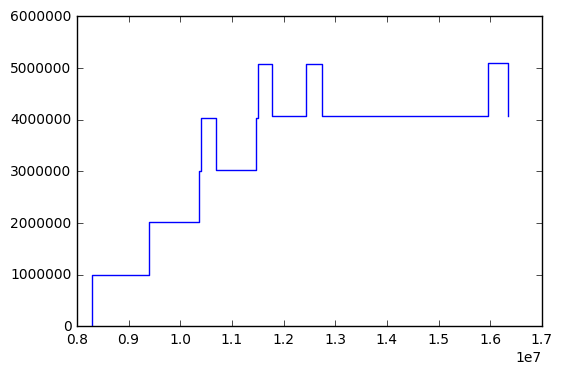

In [4]:
sess = create_session()
open_tag('mem')
sess.run(init_op)
close_tag('mem')
stderr=grab_output('mem')
plot_memory_timeline(stderr, True)

In [6]:
print_memory_timeline(stderr, True)

  8287100                                 zeros(3)     1000192     1000192 gpu_bfc
  9403718                               zeros_1(4)     1010176     2010368 gpu_bfc
 10358197                                 zeros(3)     1000192     3010560 gpu_bfc
 10408403                               zeros_2(5)     1020160     4030720 gpu_bfc
 10700982                                 zeros(3)    -1000192     3030528 gpu_bfc
 11464560                               zeros_1(4)     1010176     4040704 gpu_bfc
 11501206                               zeros_3(6)     1030144     5070848 gpu_bfc
 11784330                               zeros_1(4)    -1010176     4060672 gpu_bfc
 12433383                               zeros_2(5)     1020160     5080832 gpu_bfc
 12745358                               zeros_2(5)    -1020160     4060672 gpu_bfc
 15962997                               zeros_3(6)     1030144     5090816 gpu_bfc
 16338900                               zeros_3(6)    -1030144     4060672 gpu_bfc


In [7]:
print_memory_timeline(stderr)

  4970132                               zeros_4(7)     1000000     1000000 cpu
  5049983                               zeros_4(7)    -1000000           0 cpu
  8240339                                      (1)     1048576     1048576 cuda_host_bfc
  8287100                                 zeros(3)     1000192     2048768 gpu_bfc
  8627152                                      (1)    -1048576     1000192 cuda_host_bfc
  9023603                               zeros_5(8)     1010000     2010192 cpu
  9087930                               zeros_5(8)    -1010000     1000192 cpu
  9403718                               zeros_1(4)     1010176     2010368 gpu_bfc
 10027839                               zeros_6(9)     1020000     3030368 cpu
 10085383                               zeros_6(9)    -1020000     2010368 cpu
 10358197                                 zeros(3)     1000192     3010560 gpu_bfc
 10408403                               zeros_2(5)     1020160     4030720 gpu_bfc
 10700982       

# Allocate 10GB variable using in-place initializer

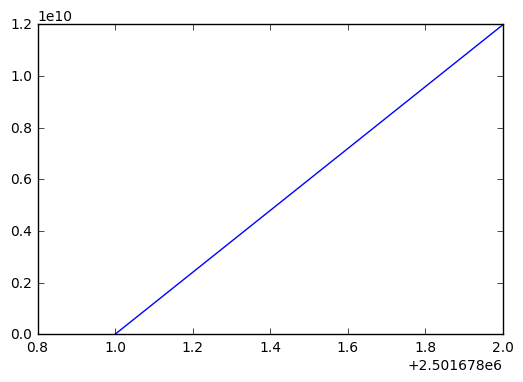

In [14]:
tf.reset_default_graph()
var = tf.Variable(tf.zeros_initializer(10*10**9/4,))
var_zero = tf.contrib.framework.zero_initializer(var)
sess = create_session()
open_tag('mem')
sess.run(var_zero)
close_tag('mem')
stderr=grab_output('mem')
plot_memory_timeline(stderr, True)

In [15]:
print_memory_timeline(stderr, True)

  2501680                     zero_initializer(67) 11971143168 11971143168 gpu_bfc


# Test that session del frees memory

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf

def allocate(k):
    tf.reset_default_graph()
    sess = tf.Session()
    var_size = 10**9/4 # 1 GB
    for i in range(k):
        with tf.device("/gpu:0"):
            var = tf.Variable(tf.zeros_initializer(var_size))
            sess.run(var.initializer)
            print("Allocated "+str(i))
    del sess
    
allocate(4)

Allocated 0
Allocated 1
Allocated 2
Allocated 3


In [11]:
allocate(4)

Allocated 0
Allocated 1
Allocated 2
Allocated 3


In [12]:
allocate(4)

Allocated 0
Allocated 1
Allocated 2
Allocated 3


In [13]:
allocate(4)

Allocated 0
Allocated 1
Allocated 2
Allocated 3


# End